# Multi Layer Perceptron Classification

## 2.1 - Model Building from Scratch

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

wine_data = pd.read_csv('WineQT.csv')
wine_data = wine_data.drop(["Id"],axis=1)
colums = wine_data.columns
wine_data.head()
n_classes = wine_data["quality"].unique()
wine_data = np.array(wine_data)

In [27]:
# Partition the dataset into train, validation, and test sets.
from sklearn.model_selection import train_test_split

X = wine_data[:, :-1]
y = wine_data[:, -1]

y = y-3 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train[0])

[ 8.7     0.84    0.      1.4     0.065  24.     33.      0.9954  3.27
  0.55    9.7   ]


In [28]:
# Normalise and standarize the data. Make sure to handle the missing or inconsistent data values if necessary.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

# output data is not scaled because we want to test the model on the original data

In [39]:
# class for MLP classifier
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import numpy as np

class MLPClassifier:
    def __init__(self, n_inputs, n_hidden_units, n_classes, learning_rate=0.01, n_epochs=1000, activation='sigmoid', optimizer='sgd', batch_size=None):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.activation = activation
        self.optimizer = optimizer
        self.losses = []
        
        # Initialize weight matrices with bias included for hidden and output layers
        self.weights = []
        self.weights.append(np.random.randn(n_inputs + 1, n_hidden_units[0]))  # Input to first hidden layer
        for i in range(1, len(n_hidden_units)):
            self.weights.append(np.random.randn(n_hidden_units[i - 1] + 1, n_hidden_units[i]))  # Hidden layers
        self.weights.append(np.random.randn(n_hidden_units[-1] + 1, n_classes))  # Last hidden layer to output

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def relu(self, x):
        return np.maximum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    def softmax(self, z):
        exps = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def activate(self, x):
        if self.activation == 'sigmoid':
            return self.sigmoid(x)
        elif self.activation == 'relu':
            return self.relu(x)
        elif self.activation == 'tanh':
            return self.tanh(x)

    def activate_derivative(self, x):
        if self.activation == 'sigmoid':
            return x * (1 - x)
        elif self.activation == 'relu':
            return 1. * (x > 0)
        elif self.activation == 'tanh':
            return 1 - x**2

    def add_bias(self, X):
        # Add bias (column of 1s) to the input at the last index
        return np.insert(X, len(X[0]), 1, axis=1)
        
    def forward_propagation(self, X):
        activations = [X]
        for w in self.weights[:-1]:
            current_output = self.activate(np.dot(self.add_bias(activations[-1]), w))
            activations.append(current_output)
        
        # Final layer uses softmax for multi-class classification
        final_output = np.dot(self.add_bias(activations[-1]), self.weights[-1])
        output = self.softmax(final_output)
        activations.append(output)
        
        return activations

    def backward_propagation(self, X, y, activations):
        output_error = y - activations[-1]
        deltas = [output_error]
        
        for i in range(len(self.weights) - 1, 0, -1):
            error = deltas[-1].dot(self.weights[i][:-1, :].T)
            delta = error * self.activate_derivative(activations[i])
            deltas.append(delta)

        deltas.reverse()

        # Update weights (including bias)
        for i in range(len(self.weights)):
            activation_with_bias = self.add_bias(activations[i])
            self.weights[i] += self.learning_rate * activation_with_bias.T.dot(deltas[i])

    def categorical_cross_entropy_loss(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred)) / len(y_true)
    
    def one_hot_encode(self, y, n_classes):
        one_hot_y = np.zeros((len(y), n_classes))
        for i, val in enumerate(y):
            one_hot_y[i, int(val)] = 1
        return one_hot_y
    
    def fit(self, X, y):
        if self.optimizer == 'sgd':
            self.train_sgd(X, y)
        elif self.optimizer == 'bgd':
            self.train_bgd(X, y)
        elif self.optimizer == 'mbgd':
            self.train_mbgd(X, y)


    def train_sgd(self, X, y):
        y_encoded = self.one_hot_encode(y, self.weights[-1].shape[1])

        for epoch in range(self.n_epochs):
            for i in range(len(X)):
                X_batch = X[i:i+1]
                y_batch = y_encoded[i:i+1]
                activations = self.forward_propagation(X_batch)
                self.backward_propagation(X_batch, y_batch, activations)
            self.losses.append(self.categorical_cross_entropy_loss(y_batch, activations[-1]))

    def train_bgd(self, X, y):
        y_encoded = self.one_hot_encode(y, self.weights[-1].shape[1])

        for epoch in range(self.n_epochs):
            activations = self.forward_propagation(X)
            self.backward_propagation(X, y_encoded, activations)

    def train_mbgd(self, X, y):
        y_encoded = self.one_hot_encode(y, self.weights[-1].shape[1])

        for epoch in range(self.n_epochs):
            for i in range(0, len(X), self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y_encoded[i:i+self.batch_size]
                activations = self.forward_propagation(X_batch)
                self.backward_propagation(X_batch, y_batch, activations)

    def predict(self, X):
        activations = self.forward_propagation(X)
        return np.argmax(activations[-1], axis=1)
    
    


In [25]:
# MLP = MLP_Classifier(n_inputs=11, n_outputs=6, n_neuron=[5], lr=0.05, act_func='sigmoid', optimizer='bgd')
# MLP.fit(X_train_scaled, y_train, epochs=1000)
# y_pred = MLP.predict(X_val_scaled)
# print("Accuracy: ", accuracy_score(y_val, y_pred)*100)

from sklearn.metrics import accuracy_score
MLP = MLPClassifier(n_inputs=11, n_hidden_units=[3,5], n_classes=6, learning_rate=0.01, n_epochs=1000, batch_size=64, activation='sigmoid', optimizer='bgd')
MLP.fit(X_train_scaled, y_train)
y_pred = MLP.predict(X_test_scaled)
print("Accuracy: ", accuracy_score(y_test, y_pred)*100)

Accuracy:  58.515283842794766


### Hyperparameters tuning

In [6]:
%pip install wandb -qU

Note: you may need to restart the kernel to use updated packages.


In [7]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guptayatharth1. Use `wandb login --relogin` to force relogin


True

In [8]:
wandb.init(
    project="MLP-Classification",
    resume=True
)

In [9]:
# Initialize Weights & Biases Sweep
sweep_config = {
    'method': 'grid',  # You can choose different sweep methods (grid, random, etc.)
    'name': 'MLP-Classification_sweep',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': {
        'lr': {'values': [ 0.005, 0.01, 0.1]},  # Learning rate values to experiment with
        'num_epochs': {'values': [200, 500, 1000]},  # Number of epochs to experiment with
        'hidden_layers': {'values': [[3], [2, 5], [10, 20], [2, 5, 10], [10, 20, 40]]},  # Hidden layer architecture to experiment with
        'activation': {'values': ['sigmoid', 'relu', 'tanh']},  # Activation function to experiment with
        'optimizer': {'values': ['sgd', 'bgd', 'mbgd']},  # Optimizer to experiment with
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="MLP-Classification")

Create sweep with ID: 5ruy0g45
Sweep URL: https://wandb.ai/guptayatharth1/MLP-Classification/sweeps/5ruy0g45


In [10]:
# hyperparameter tuning
# learning rate
# hidden layers
# number of neurons in each layer
# activation functions
# epochs

# all_lr = [0.001, 0.005]
# all_neurons = [[2], [10, 20],[2, 5, 10],[10, 20, 40]]
# all_act_func = ['sigmoid', 'relu', 'tanh']
# all_epochs = [200, 500, 1000]
# all_lr = [0.001, 0.005, 0.01, 0.05, 0.1]
# all_neurons = [[2],[4],[10],[2, 5], [4, 8], [10, 20], [10,9,5], [10,6,8,7,4,9],[2, 5, 10], [4, 8, 16], [10, 20, 40]]
# all_act_func = ['sigmoid', 'relu', 'tanh']
# all_epochs = [50, 100, 200, 500, 1000, 5000]


def train():
    # Initialize Weights & Biases run
    with wandb.init() as run:
        # Configure the logistic regression model with hyperparameters
        config = run.config
        model = MLPClassifier(n_inputs=11, n_hidden_units=config.hidden_layers, n_classes=6, learning_rate=config.lr, n_epochs=config.num_epochs, batch_size=64, activation=config.activation)

        # Fit the model
        model.fit(X_train_scaled, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_val_scaled)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)

        # Log the hyperparameters and accuracy to the current run
        wandb.log({"val_accuracy": accuracy*100})

# Run the sweep
wandb.agent(sweep_id, function=train)
wandb.finish()


# best_acc = 0
# best_lr = None
# best_hidden_layers = None
# best_neurons = None
# best_act_func = None
# best_epochs = None

# n_inputs = colums.shape[0]-1

# for lr in all_lr:
#     for neurons in all_neurons:
#         for act_func in all_act_func:
#             for epochs in all_epochs:
#                 model = MLPClassifier(n_inputs=n_inputs, n_hidden_units=neurons, n_classes=6, learning_rate=lr, n_epochs=epochs, batch_size=64, activation=act_func, optimizer='bgd')
#                 model.fit(X_train_scaled, y_train)
#                 Y_pred = model.predict(X_val_scaled)
#                 acc = accuracy_score(y_val, Y_pred)*100
#                 # print("Learning Rate: ", lr, "Neurons: ", neurons, "Activation Function: ", act_func, "Epochs: ", epochs, "Accuracy: ", acc)

#                 if acc > best_acc:
#                     best_acc = acc
#                     best_lr = lr
#                     best_hidden_layers = len(neurons)
#                     best_neurons = neurons
#                     best_act_func = act_func
#                     best_epochs = epochs

# print("Best Accuracy: ", best_acc)
# print("Best Learning Rate: ", best_lr)
# print("Best Hidden Layers: ", best_hidden_layers)
# print("Best Neurons: ", best_neurons)
# print("Best Activation Function: ", best_act_func)
# print("Best Epochs: ", best_epochs)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: 84d8fkqf with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread Exception in thread     NetStatThrIntMsgThrself.run():
:

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 953, in run
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 286, in check_stop_status
        self.run()    self._loop_check_status(
self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run

  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 224, in _loop_check_status
  File "/usr/lib/python3.10/threading.py", line 953, in run
        local_handle = request()   

val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: 3tw6k1ji with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: ie62jyqv with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: p1j7ausl with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,62.29508


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9kbk5f30 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: 262ni8bn with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6ta6ftob with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: zphdsl4c with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: asxua91u with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r15llxrd with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: obrqqtsz with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,61.74863


wandb: Agent Starting Run: 7fnld1n3 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: sv9z8akq with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: 5380rn5y with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,62.29508


wandb: Agent Starting Run: rftvh7ai with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rsktkqfp with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,63.93443


wandb: Agent Starting Run: zyu8jkis with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: r5d31tfu with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,61.74863


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rzwyw7p6 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: 5mgwa9s3 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: 3edunv28 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: bvsdc1h3 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x9hqua7e with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,61.74863


wandb: Agent Starting Run: g3ys7g4l with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eja6xsun with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: bfku4lqb with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: ooolbrwa with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: abh9ntdh with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,61.74863


wandb: Agent Starting Run: 2jsmr4yp with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ngwr2tuh with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: soue3beo with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,61.74863


wandb: Agent Starting Run: 3ukcoq86 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: p8smuvp0 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: eymk8zs5 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: l3dghwko with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2g12wvgd with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,63.93443


wandb: Agent Starting Run: 4wrfcxxx with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mh66rsjg with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: 8ttu1n0f with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: 0yux0mtx with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: 8vdy5ta0 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: i4y0ao6v with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: f6u594cs with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: 7zlz9f70 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: ojgujfii with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: wna3k4zq with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,54.64481


wandb: Agent Starting Run: mue9ijib with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: lb51c89o with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: xfytzw1b with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: fc218mab with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: ulfaioxd with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: ustbg3fc with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: tk6chq0u with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: d2kguq2e with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: 6ackpx13 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jsjpyfdv with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: 67vfk44n with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,62.29508


wandb: Agent Starting Run: o92vv6ya with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: ybyyiyad with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ra49aavk with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: 523jpp6k with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: rkyeivqk with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Agent Starting Run: uoq4h9fj with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: ucg62064 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Agent Starting Run: s8xt9q8j with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dp8x1wsc with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,61.74863


wandb: Agent Starting Run: eezmhguh with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rolvtbgv with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: spe02s7p with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: ibak3gb5 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: 04phlzit with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hkl6bgp5 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,53.55191


wandb: Agent Starting Run: q1kopuu7 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: ailkc4qp with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,50.81967


wandb: Agent Starting Run: bgniqueg with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: 14hibuo9 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,46.99454


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fgn76dob with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,48.63388


wandb: Agent Starting Run: ptopcjl4 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: 3lhncyav with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: dmzekedl with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,55.19126


wandb: Agent Starting Run: uxw0acds with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Agent Starting Run: dxkkgktk with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: 2voj41cc with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: s9yv81nf with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,61.74863


wandb: Agent Starting Run: g249xidu with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: nqphxnin with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: phutrhgc with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 25amd844 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Agent Starting Run: a9gy8qd4 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p6p01v9n with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,62.29508


wandb: Agent Starting Run: tuyqo6v5 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: km2ld8ye with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,61.74863


wandb: Agent Starting Run: njoy4l13 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: fmqd9l4q with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: 5wnamr1o with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m8m1ue1o with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: 6s1phsts with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: sdzf14rh with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: a3h0n1uj with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: slexfjyd with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: gwakyc11 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: t9xq5pny with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: 4q31iq93 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h0b1nbns with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: mp54ravs with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: 3i89x616 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: kfczi2d2 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: g40k3xx5 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: 0o8o2zh8 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: o6zpkkka with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: fjw28o1g with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: jeomx3sp with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: uu5yll8w with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,61.74863


wandb: Agent Starting Run: 6q8sizko with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: cmme9kxn with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,51.91257


wandb: Agent Starting Run: qinwyf1x with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,46.99454


wandb: Agent Starting Run: 2vjpxowm with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2rqxlco5 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: 3xhmdf09 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: xcw0eh2o with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: sddca3jz with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,52.45902


wandb: Agent Starting Run: 22x4eupm with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: rw2aib7d with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: 0mp9p1yw with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,50.27322


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o0z8sz8q with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,49.72678


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iigt7gz5 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: xr8r3u0u with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: biy66ysa with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: 7s6n5lr1 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,49.18033


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: roy796yp with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,50.27322


wandb: Agent Starting Run: 66ndwnud with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,53.55191


wandb: Agent Starting Run: 02ob8mhj with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: ivadtnh7 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: eh8ke87l with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bmk1ncbn with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,53.00546


wandb: Agent Starting Run: 7lv1oyz0 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,62.29508


wandb: Agent Starting Run: 8ibb5nrs with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,61.74863


wandb: Agent Starting Run: 386lhjri with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,62.29508


wandb: Agent Starting Run: u49qdtyn with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: n7sh3z4p with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jpmnw7jw with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,63.93443


wandb: Agent Starting Run: 9sjogp68 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: kc6vjkam with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,61.74863


wandb: Agent Starting Run: nyyzr2zj with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Agent Starting Run: bbt3iquc with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: rntcrzls with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: pr0e3cwq with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: ilwhlad3 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: g5mv6lbp with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: tdq5qk26 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tvt5tzid with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: nqe1l396 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: cyreqmht with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: silgend9 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: zqmn5qyd with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mz84w5s8 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: jhuvqhbw with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: u4j1ty1u with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,50.81967


wandb: Agent Starting Run: eswai3ev with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: btg8rg8v with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: nkj2hsx2 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: el5apvev with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: xpwhkll6 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qujpic3x with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: h0wg82zz with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Agent Starting Run: kjdrjdnz with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: 14umy49k with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: scfgqr9u with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,62.84153


wandb: Agent Starting Run: nx5pgknr with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: cnie5rvo with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: th0p97qz with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dr8f1wiv with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m9d8d3xx with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: tzf5h6l8 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: n7zko6ba with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,42.62295


wandb: Agent Starting Run: g8yyz2me with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: cw2ycdqj with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: 7wgz5o28 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: fm6njlvb with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d3doii0z with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,62.29508


wandb: Agent Starting Run: 99ygno9q with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,54.09836


wandb: Agent Starting Run: gea3jeto with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 133czzka with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9nrld435 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,53.55191


wandb: Agent Starting Run: laxajwce with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: 0mn7lqby with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: 5hxy6n86 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,53.00546


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jrbt83xs with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ly5naa18 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: 5ekssc36 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: g4hebfkf with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s3km9m9d with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,53.55191


wandb: Agent Starting Run: w20wuug7 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,53.55191


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vvdkj342 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: uwbs0ng7 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: utajkzc5 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,48.08743


wandb: Agent Starting Run: o6yl9lg3 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,46.44809


wandb: Agent Starting Run: ls3mtg7q with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,51.91257


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t387aj3k with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,50.27322


wandb: Agent Starting Run: y7ziuca1 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,46.99454


wandb: Agent Starting Run: ul25fsro with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,54.64481


wandb: Agent Starting Run: 5f8dv326 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: pfd32yor with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,48.63388


wandb: Agent Starting Run: lfzf0cwp with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: 145e77ai with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,54.09836


wandb: Agent Starting Run: uiv7v291 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,53.00546


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4yf5yp5s with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l4lz0ovn with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2iwpbuq6 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: xfb10lm4 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,46.99454


wandb: Agent Starting Run: jb8g4dxb with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: fu6vcywr with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,44.80874


wandb: Agent Starting Run: o778m52y with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: n4kawscc with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,50.81967


wandb: Agent Starting Run: kfz5cpf0 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: zp2vnegg with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,53.00546


wandb: Agent Starting Run: tf9054m2 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: qes1lcna with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: fo3ncikv with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: 47ud7hqa with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: v9ypl26i with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,53.55191


wandb: Agent Starting Run: 3ywh4dbj with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: intgyo3o with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: mj07y4vy with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: y08v1u8c with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: 4herujru with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: h7iggfoa with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sfbhe2vh with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: 0d9zoyxv with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: o48drzd5 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: iaj788b9 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,62.29508


wandb: Agent Starting Run: fho99dvf with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: uiv9jqu0 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,62.84153


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: atj0jii7 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: 2qk7zgrl with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sd9uvoxz with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: aonf58nq with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: oh8x58dl with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: 19ho2j24 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: k015707o with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: 3yn7506v with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,51.91257


wandb: Agent Starting Run: 1ehb6rpf with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,54.09836


wandb: Agent Starting Run: ybpvks7r with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,52.45902


wandb: Agent Starting Run: 78zsscmc with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,55.19126


wandb: Agent Starting Run: zg17kxd1 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iu4hxjru with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: ua6hpn2j with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,54.64481


wandb: Agent Starting Run: k6p6hs80 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,53.00546


wandb: Agent Starting Run: f99km7gy with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,55.19126


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6jkbcivc with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,51.91257


wandb: Agent Starting Run: w4pq6ga0 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,53.00546


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6405e575 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,48.63388


wandb: Agent Starting Run: 01x4yuok with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,54.64481


wandb: Agent Starting Run: xcq6bbkh with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: vpg65jol with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ssfccs9e with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,53.55191


wandb: Agent Starting Run: 0crw5jf6 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l91p3f53 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: o8txs713 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: y8m72lab with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v3930e91 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: 1x2ooklm with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,43.71585


wandb: Agent Starting Run: sup9dzdq with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: s7d7kei0 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: pat3hgqq with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: lerdn6ov with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


/tmp/ipykernel_26818/911688638.py:267: RuntimeWarning: invalid value encountered in multiply
  delta = error * self.activate_derivative(activations[i])


val_accuracy,▁
val_accuracy,0.54645


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nbrcmnu1 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: 3af08lcr with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: 5x2fthzi with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: gdgyc95k with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: u96c6rva with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: wkp43xye with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: jabftwhv with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Agent Starting Run: 4rcqz57m with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: hvpw77pd with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,55.19126


wandb: Agent Starting Run: s28y8xe3 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: fnif3fto with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: w38b2q2t with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: vw7hwj88 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: csf8k0hk with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 31mpyid6 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: d2w7wstx with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: qbrugujh with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r0d8nn54 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: r36a3n05 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,54.64481


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9vg2cspy with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: 55hholb3 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: b8vnrud4 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: vu4m5ev1 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: mvbl7xvp with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: sp31bchq with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,54.64481


wandb: Agent Starting Run: s5otqtw9 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,55.19126


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oybrlaro with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,55.19126


wandb: Agent Starting Run: 583u2nwk with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: sqyunj1o with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: x1h8701i with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: 4k7e40jl with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [3]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: d66ttjlz with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,55.19126


wandb: Agent Starting Run: om0v6bwo with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jfkrou48 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: 51ic99yd with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: rvtbsgct with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mw980i52 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,55.19126


wandb: Agent Starting Run: jsexxgor with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,63.93443


wandb: Agent Starting Run: 4rmo8kn4 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: zkx4zbbh with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: 2q3qo7ta with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hcbd2fl8 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.65574


wandb: Agent Starting Run: sm9nk4a9 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: ca6v8tb5 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Agent Starting Run: 0ce2saoy with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: 3t3o41hn with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,61.20219


wandb: Agent Starting Run: oqa7alnd with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: xkgojg90 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: p77uqp71 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: bt7nadnu with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Agent Starting Run: wws41732 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: ddolrbno with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,55.19126


wandb: Agent Starting Run: fzjoumda with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,53.55191


wandb: Agent Starting Run: bjhls1ph with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: ykuyqo8w with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: hpy71unu with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,50.27322


wandb: Agent Starting Run: yzun4qia with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: v9ufnrgy with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: o8jcp1zn with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,52.45902


wandb: Agent Starting Run: hv8tiei0 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Agent Starting Run: uunqexk2 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,54.64481


wandb: Agent Starting Run: vw8msyjv with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,47.54098


wandb: Agent Starting Run: hel7tx8s with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: apbaq7z6 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,51.36612


wandb: Agent Starting Run: as4jfuf7 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,52.45902


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2wyo0but with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,45.35519


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tbuqf0a2 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,50.81967


wandb: Agent Starting Run: re1if8ix with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,50.81967


wandb: Agent Starting Run: nqz75xjv with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,49.72678


wandb: Agent Starting Run: kfjl2yh6 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o1v8ikhh with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,53.55191


wandb: Agent Starting Run: xqrwmiaw with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,51.91257


wandb: Agent Starting Run: 78kj1t85 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,47.54098


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: my64uudb with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: nq2f8clo with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,54.09836


wandb: Agent Starting Run: upmay2h7 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,50.81967


wandb: Agent Starting Run: 9p18kl0u with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: v633sme3 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,51.36612


wandb: Agent Starting Run: 5935rf8q with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,48.63388


wandb: Agent Starting Run: 16ds0o70 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,52.45902


wandb: Agent Starting Run: ocew91tj with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,51.36612


wandb: Agent Starting Run: k1smdum9 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,53.00546


wandb: Agent Starting Run: 4nzu0xbt with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,52.45902


wandb: Agent Starting Run: ph4fgt0y with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,49.18033


wandb: Agent Starting Run: bkpvsq0u with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Agent Starting Run: awz9l0w4 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: lppwiwmf with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: e3yjfgfq with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: siiozyvq with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,54.64481


wandb: Agent Starting Run: qtmpz57g with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,55.7377


wandb: Agent Starting Run: rxl9wstk with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Agent Starting Run: y2920x87 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,56.28415


wandb: Agent Starting Run: uotbwn52 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: crttvd1c with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,55.19126


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t5pj79lz with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: 66v3fblm with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: klbxcdc0 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: nqlsinrf with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,54.64481


wandb: Agent Starting Run: 4yt7pfqs with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: zuvh52bu with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.56284


wandb: Agent Starting Run: h0c1uwsu with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: 30wwzmx4 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: p7nqggi9 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Agent Starting Run: 8wgqbrpe with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.9235


wandb: Agent Starting Run: bxc0ukw9 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,58.46995


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m9r1pm45 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,51.91257


wandb: Agent Starting Run: pzst20za with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: 6bn4mqb3 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,60.10929


wandb: Agent Starting Run: ibqm1opc with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: iveybzrb with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Agent Starting Run: 7r2j8u51 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,56.8306


wandb: Agent Starting Run: wq9byq5a with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,49.72678


wandb: Agent Starting Run: fhk7s8hj with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,53.55191


wandb: Agent Starting Run: jwq1nvf4 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,48.08743


wandb: Agent Starting Run: a8sqr6ew with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,45.90164


wandb: Agent Starting Run: 148p9zy7 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,51.91257


wandb: Agent Starting Run: 1d17yyyr with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6g3e2q4q with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,53.00546


wandb: Agent Starting Run: 74zl6fl6 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,53.55191


wandb: Agent Starting Run: lkkeutag with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: 9hpj91mx with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,45.90164


wandb: Agent Starting Run: 07eant1x with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,57.37705


wandb: Agent Starting Run: bs7b7mjq with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,54.09836


wandb: Agent Starting Run: hicnmmnu with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,49.72678


wandb: Agent Starting Run: qoa7vajm with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,50.81967


wandb: Agent Starting Run: g0idso7q with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,51.91257


wandb: Agent Starting Run: efpl94ex with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,59.01639


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8s7x2ox6 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,54.09836


wandb: Agent Starting Run: 8vh17asq with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,48.63388


wandb: Agent Starting Run: jt0lclwk with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,51.91257


wandb: Agent Starting Run: a5iwu3ux with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,54.09836


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g1jt9k14 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,44.2623


wandb: Agent Starting Run: dxlzygbz with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,46.44809


wandb: Agent Starting Run: um279lro with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,55.19126


wandb: Agent Starting Run: dfpnvfgv with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,50.27322


wandb: Agent Starting Run: o1vr9ip1 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,45.35519


wandb: Agent Starting Run: x10g2myb with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


val_accuracy,▁
val_accuracy,48.08743


wandb: Agent Starting Run: u8yu4qxt with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


val_accuracy,▁
val_accuracy,49.72678


wandb: Agent Starting Run: ptop7deb with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.1
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


val_accuracy,▁
val_accuracy,53.55191


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f1f2d27bfa0>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

Accuracy:  59.82532751091703
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.00      0.00      0.00         6
         2.0       0.68      0.83      0.75       107
         3.0       0.56      0.41      0.47        86
         4.0       0.36      0.48      0.41        27
         5.0       0.00      0.00      0.00         1

    accuracy                           0.60       229
   macro avg       0.27      0.29      0.27       229
weighted avg       0.57      0.60      0.58       229

[[ 0  0  2  0  0  0]
 [ 0  0  3  2  1  0]
 [ 0  0 89 17  1  0]
 [ 0  0 31 35 20  0]
 [ 0  0  5  9 13  0]
 [ 0  0  0  0  1  0]]


/home/yatharth-gupta/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yatharth-gupta/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yatharth-gupta/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(95.72222222222221, 0.5, 'Truth')

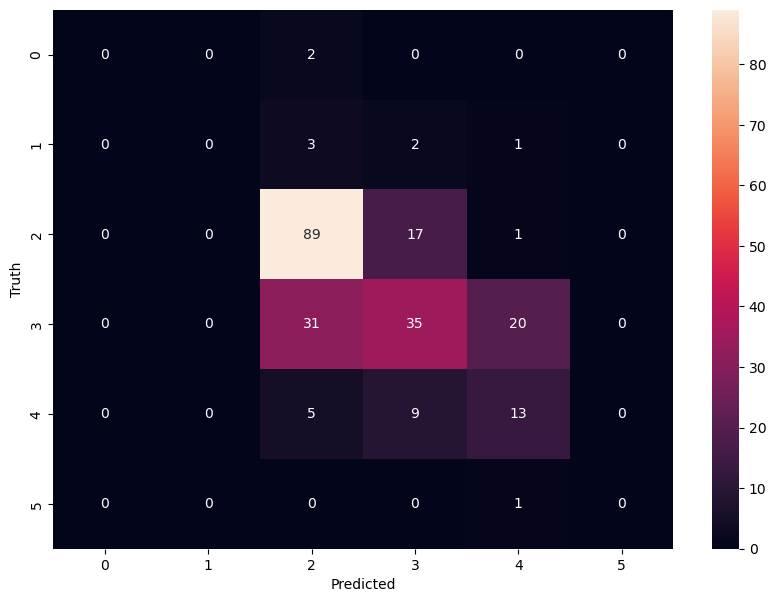

In [40]:
# accuracy, f-1 score, precision, and recall on the test set

model = MLPClassifier(n_inputs=11, n_hidden_units=[2,5], n_classes=6, learning_rate=0.005, n_epochs=1000, batch_size=64, activation='tanh', optimizer='sgd')
model.fit(X_train_scaled, y_train)
Y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, Y_pred)*100
print("Accuracy: ", acc)

from sklearn.metrics import classification_report
print(classification_report(y_test, Y_pred))

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, Y_pred)
print(cm)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


Text(0.5, 1.0, 'Loss Curve')

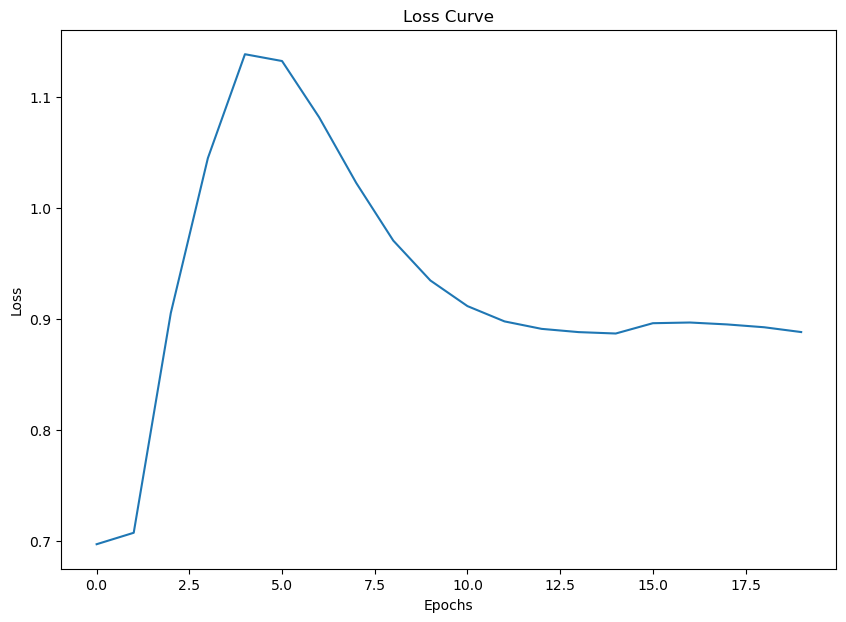

In [41]:
# plot the loss curve at intervals of 50 epochs
plt.figure(figsize=(10,7))
plt.plot(model.losses[::50])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')

#### Results are better than logistic regression with a small margin

## Mutli-label Classification

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

advertisment = pd.read_csv('advertisement.csv')

advertisment = np.array(advertisment)
#preprocessing
sorted_labels = [' '.join(sorted(labels)) for labels in [x.split(' ') for x in advertisment[:,10]]]
advertisment[:,10] = sorted_labels

# Convert to a DataFrame
columns = ['Age', 'Gender', 'Salary', 'Education', 'Married', 'Children', 'Location', 'Occupation', 'Expense', 'Purchase', 'Labels']
df = pd.DataFrame(advertisment, columns=columns)

# Separate categorical and numerical features
categorical_cols = ['Gender', 'Education', 'Location', 'Occupation', 'Purchase','Married']
numerical_cols = ['Age', 'Salary', 'Children', 'Expense']
label = ['Labels']

# apply label encoding to categorical features
le = LabelEncoder()
X_categorical = np.array([le.fit_transform(df[col]) for col in categorical_cols]).T

# convert labels to binary vectors 
labels = df['Labels'].apply(lambda x: x.split())
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
X_numerical = df[numerical_cols].values

# Combine label encoded and numerical features
X = np.hstack((X_categorical, X_numerical))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = X_train.astype(float)
X_test = X_test.astype(float)



In [ ]:
# import numpy as np

# class MLPClassifier_multilabel:
#     def __init__(self, n_inputs, n_hidden_units, n_classes, learning_rate=0.01, n_epochs=1000, activation='sigmoid', optimizer='sgd', batch_size=None):
#         self.learning_rate = learning_rate
#         self.n_epochs = n_epochs
#         self.batch_size = batch_size
#         self.activation = activation
#         self.optimizer = optimizer
        
#         # Initialize weight matrices with bias included for hidden and output layers
#         self.weights = []
#         self.weights.append(np.random.randn(n_inputs + 1, n_hidden_units[0]))  # Input to first hidden layer
#         for i in range(1, len(n_hidden_units)):
#             self.weights.append(np.random.randn(n_hidden_units[i - 1] + 1, n_hidden_units[i]))  # Hidden layers
#         self.weights.append(np.random.randn(n_hidden_units[-1] + 1, n_classes))  # Last hidden layer to output

#     def sigmoid(self, x):
#         return 1 / (1 + np.exp(-x))

#     def relu(self, x):
#         return np.maximum(0, x)

#     def tanh(self, x):
#         return np.tanh(x)

#     def softmax(self, z):
#         exps = np.exp(z - np.max(z, axis=1, keepdims=True))
#         return exps / np.sum(exps, axis=1, keepdims=True)

#     def activate(self, x):
#         if self.activation == 'sigmoid':
#             return self.sigmoid(x)
#         elif self.activation == 'relu':
#             return self.relu(x)
#         elif self.activation == 'tanh':
#             return self.tanh(x)

#     def activate_derivative(self, x):
#         if self.activation == 'sigmoid':
#             return x * (1 - x)
#         elif self.activation == 'relu':
#             return 1. * (x > 0)
#         elif self.activation == 'tanh':
#             return 1 - x**2

#     def add_bias(self, X):
#         # Add bias (column of 1s) to the input at the last index
#         ret = np.insert(X, len(X[0]), 1, axis=1)
#         # print(ret.shape)
#         return ret
        
#     def forward_propagation(self, X):
#         activations = [X]
#         current_input = X
#         for w in self.weights[:-1]:
#             z = np.dot(self.add_bias(current_input), w)
#             current_output = self.activate(z)
#             activations.append(current_output)
#             current_input = current_output
        
#         # Final layer uses sigmoid for multi-label classification
#         final_output = np.dot(self.add_bias(current_input), self.weights[-1])
#         # print(final_output[0])
#         output = self.sigmoid(final_output)
#         activations.append(output)
        
#         return activations

#     def backward_propagation(self, X, y, activations):
#         output_error = y - activations[-1]
#         deltas = [output_error*self.activate_derivative(activations[-1])]
        
#         for i in range(len(self.weights) - 1, 0, -1):
#             error = deltas[-1].dot(self.weights[i][:-1, :].T)
#             delta = error * self.activate_derivative(activations[i])
#             deltas.append(delta)

#         deltas.reverse()

#         # Update weights (including bias)
#         for i in range(len(self.weights)):
#             activation_with_bias = self.add_bias(activations[i])
#             self.weights[i] += self.learning_rate * activation_with_bias.T.dot(deltas[i])
#     def binary_cross_entropy_loss(self, y_true, y_pred):
#         epsilon = 1e-10
#         y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
#         return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

#     # def one_hot_encode(self, y, n_classes):
#     #     one_hot_y = np.zeros((len(y), n_classes))
#     #     for i, targets in enumerate(y):
#     #         for val in targets:
#     #             one_hot_y[i, int(val)] = 1
#     #     return one_hot_y
    
#     def fit(self, X, y):
#         if self.optimizer == 'sgd':
#             self.train_sgd(X, y)
#         elif self.optimizer == 'bgd':
#             self.train_bgd(X, y)
#         elif self.optimizer == 'mbgd':
#             self.train_mbgd(X, y)


#     # def train_sgd(self, X, y):
#     #     y_encoded = self.one_hot_encode(y, 8)
#     #     for epoch in range(self.n_epochs):
#     #         for i in range(len(X)):
#     #             X_batch = X[i:i+1]
#     #             y_batch = y_encoded[i:i+1]
#     #             activations = self.forward_propagation(X_batch)
#     #             self.backward_propagation(X_batch, y_batch, activations)

#     def train_bgd(self, X, y):
#         # print(y[0])
#         # y_encoded = self.one_hot_encode(y, 8)
#         # print(y_encoded[0])
#         for epoch in range(self.n_epochs):
#             activations = self.forward_propagation(X)
#             self.backward_propagation(X, y, activations)

#     # def train_mbgd(self, X, y):
#     #     y_encoded = self.one_hot_encode(y, 8)

#     #     for epoch in range(self.n_epochs):
#     #         for i in range(0, len(X), self.batch_size):
#     #             X_batch = X[i:i+self.batch_size]
#     #             y_batch = y_encoded[i:i+self.batch_size]
#     #             activations = self.forward_propagation(X_batch)
#     #             self.backward_propagation(X_batch, y_batch, activations)

#     def predict(self, X):
#         activations = self.forward_propagation(X)
#         print(activations[-1])
#         predictions = np.round(activations[-1]) # Round off predictions to 0 or 1
#         return predictions.astype(int)


import numpy as np

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of sigmoid function
def sigmoid_derivative(x):
    return x * (1 - x)

class MLPClassifier_multilabel:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.num_hidden_layers = len(hidden_sizes)
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.weights = []
        self.learning_rate = 0.01

        # Initialize weights and biases in a single matrix for each layer
        for i in range(self.num_hidden_layers + 1):
            weight = np.random.rand(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.weights.append(weight)

    def forward(self, X):
        self.activations = [X]
        output = X

        # Forward pass through the network
        for weight in self.weights:
            output = sigmoid(np.dot(output, weight))
            self.activations.append(output)

        return output

    def backward(self, X, y):
        errors = [None] * (self.num_hidden_layers + 1)
        deltas = [None] * (self.num_hidden_layers + 1)

        # Calculate error and delta for output layer
        errors[-1] = y - self.activations[-1]
        deltas[-1] = errors[-1] * sigmoid_derivative(self.activations[-1])

        # Backpropagate errors
        for i in range(self.num_hidden_layers, 0, -1):
            errors[i - 1] = deltas[i].dot(self.weights[i].T)
            deltas[i - 1] = errors[i - 1] * sigmoid_derivative(self.activations[i])

        # Update weights using gradients
        for i in range(self.num_hidden_layers + 1):
            self.weights[i] += self.activations[i].T.dot(deltas[i]) * self.learning_rate

    def train_batch_gradient_descent(self, X, y, epochs):
        for epoch in range(epochs):
            self.forward(X)
            self.backward(X, y)

    def train_stochastic_gradient_descent(self, X, y, epochs):
        for epoch in range(epochs):
            for i in range(X.shape[0]):
                sample = X[i, :].reshape(1, -1)
                target = y[i].reshape(1, -1)
                self.forward(sample)
                self.backward(sample, target)

    def train_mini_batch_gradient_descent(self, X, y, epochs, batch_size):
        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                self.forward(X_batch)
                self.backward(X_batch, y_batch)

    def fit(self, X, y, method='bgd', epochs=1000, batch_size=None):
        if method == 'bgd':
            self.train_batch_gradient_descent(X, y, epochs)
        elif method == 'sgd':
            self.train_stochastic_gradient_descent(X, y, epochs)
        elif method == 'mbgd' and batch_size is not None:
            self.train_mini_batch_gradient_descent(X, y, epochs, batch_size)
        else:
            print("Invalid method or missing batch size for Mini-Batch Gradient Descent")

    def predict(self, X):
        return self.forward(X)

In [ ]:
multi_mlp = MLPClassifier_multilabel(10, [3,5], 8)
multi_mlp.fit(X_train, y_train, method='bgd', epochs=1000)
y_pred = multi_mlp.predict(X_test)
print(y_pred)
threshold = 0.335
y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0
print("Accuracy: ", accuracy_score(y_test, y_pred)*100)

[[0.355   0.3425  0.33125 ... 0.33875 0.34625 0.35   ]
 [0.355   0.3425  0.33125 ... 0.33875 0.34625 0.35   ]
 [0.355   0.3425  0.33125 ... 0.33875 0.34625 0.35   ]
 ...
 [0.355   0.3425  0.33125 ... 0.33875 0.34625 0.35   ]
 [0.355   0.3425  0.33125 ... 0.33875 0.34625 0.35   ]
 [0.355   0.3425  0.33125 ... 0.33875 0.34625 0.35   ]]
Accuracy:  0.0
